Cythonize the 2-rounds of MST code

In [1]:
!python setup.py build_ext --inplace

running build_ext
copying build/lib.linux-x86_64-cpython-312/k_mst2.cpython-312-x86_64-linux-gnu.so -> 


Loading required packages and libraries

In [2]:
from sklearn.cluster import KMeans
import numpy as np
import math
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import cm
import random as rd
import time
import os
from sklearn.metrics import confusion_matrix
from scipy.spatial import distance
from scipy.special import comb
from scipy.sparse.linalg import eigsh
from scipy.sparse import csr_matrix, dia_matrix, diags, coo_matrix, lil_matrix
from scipy.optimize import linear_sum_assignment as linear_assignment
import seaborn
import k_mst2


# VI(s)

In [3]:
def _make_cost_m(cm):
  s = np.max(cm)
  # print(-cm, s)
  return (- cm + s)

def clustering_accuracy(clusters, classes):
  cm = confusion_matrix(clusters, classes)
  indexes = linear_assignment(_make_cost_m(cm))
  indexes = np.array(indexes).T
  js = [e[1] for e in sorted(indexes, key=lambda x: x[0])]
  cm = cm[:, js]
  return np.trace(cm) / np.sum(cm)

In [4]:
def rand_index_score(clusters, classes):
    tp_plus_fp = comb(np.bincount(clusters), 2).sum()
    tp_plus_fn = comb(np.bincount(classes), 2).sum()
    A = np.c_[(clusters, classes)]
    tp = sum(comb(np.bincount(A[A[:, 0] == i, 1]), 2).sum()
             for i in set(clusters))
    fp = tp_plus_fp - tp
    fn = tp_plus_fn - tp
    tn = comb(len(A), 2) - tp - fp - fn
    return (tp + tn) / (tp + fp + fn + tn)

# Colors and markers for visualisation

In [5]:
markers = [".", ",", "o", "v", "^", "<", ">", "1", "2", "3", "4", "8", "s", "p", "P", "*", "h", "H", "+", "x", "X", "D", "d", 4, 5, 6, 7, 8, 9 , 10, 11]
rd.shuffle(markers)
marker_colors = np.random.rand(200,3)

# Proposed clustering algorithm

### Phase I: Determining $O(N^{1/2})$ representatives using partitioning

In [6]:
def bi_means(X, X_indices, max_size, P_dash, C_dash):

    X_partition = X[X_indices]

    if len(X_indices) > max_size:

        X_indices_arr = np.array(X_indices)

        center = X_partition.mean(axis=0)

        distances = distance.cdist([center], X_partition)
        p_index = distances[0].argmax() # farthest point from rep_point

        distances = distance.cdist([X_partition[p_index]], X_partition)
        q_index = distances[0].argmax() # farthest point from p

        distances = distance.cdist(X_partition, [X_partition[p_index], X_partition[q_index]])

        min_i = distances.argmin(axis = 1)

        p_min_Is = np.where(min_i == 0)[0]
        q_min_Is = np.where(min_i == 1)[0]

        bi_means(X, X_indices_arr[p_min_Is], max_size, P_dash, C_dash)
        bi_means(X, X_indices_arr[q_min_Is], max_size, P_dash, C_dash)
    else:
        P_dash.append(X_indices)
        C_dash.append(X_partition.mean(axis=0))

In [7]:
def determine_reps(X, k_dash=10, is_plot=False):

    N, f = X.shape

    P_dash = []
    C_dash = []

    vertices = np.arange(N)

    max_size = k_dash * math.ceil(N ** 0.5)

    bi_means(X, vertices, max_size, P_dash, C_dash)
    C_dash = np.array(C_dash, dtype='float32')

    if is_plot:
        i = 0
        plt.figure(figsize = (7.5, 7.5))
        for Pj in P_dash:
            X_p = X[Pj]
            plt.scatter(X_p[:, 0], X_p[:, 1], color=marker_colors[i % 200], s=60)
            i += 1
        plt.scatter(C_dash[:, 0], C_dash[:, 1], color='C3', marker='*', edgecolor='black', linewidth=1.5, s = 300)
        plt.title("Partitions after stage-1", fontsize=20, fontweight='bold')
        plt.show()

    P = []
    R = []

    for Pj in P_dash:

        X_p = X[Pj]

        Nj = len(Pj)

        n_clusters = k_dash if Nj > k_dash else 2

        if Nj <= n_clusters and Nj > 2:
            n_clusters = 2

        if Nj <= n_clusters:
            P.append( list(Pj) )
            R.append( X_p.mean(axis=0) )
        else:
            temp_P_dash = []
            temp_C_dash = []

            max_size = math.ceil( math.ceil( Nj / n_clusters ) )
            bi_means(X, Pj, max_size, temp_P_dash, temp_C_dash)

            no_clusters = len(temp_C_dash)
            kmeans = KMeans(n_clusters=no_clusters, max_iter=20, n_init=1, init=np.array(temp_C_dash))
            kmeans.fit(X_p)

            labels = kmeans.labels_

            for i in range(no_clusters):
                R.append(kmeans.cluster_centers_[i])
                P.append( Pj[ np.where(labels == i)[0] ] )

    R = np.array(R, dtype='float32')

    if is_plot:
        i = 0
        plt.figure(figsize = (7.5, 7.5))
        for Pj in P:
            X_p = X[Pj]
            plt.scatter(X_p[:, 0], X_p[:, 1], color=marker_colors[i % 200], s=60)
            i += 1
        plt.scatter(R[:, 0], R[:, 1], color='C3', marker='*', edgecolor='black', linewidth=1.5, s = 300)
        plt.title('Final partitions after stage-2', fontsize=20, fontweight='bold')
        plt.show()

    return P, R, P_dash, C_dash

## Phase II: Finding neighbors and two-hops neighbors of representatives using MST

In [8]:
def neighboring_reps(R, num_rounds=2, is_plot=False):
    cen_distances = distance.cdist(R, R).astype('float32')

    n = len(R)
    MST_CEN = []

    us, vs = np.triu_indices(n, 1)
    us = us.astype('int32')
    vs = vs.astype('int32')
    ws = cen_distances[us, vs]
    sorted_ws = np.argsort(ws)
    vertices = np.arange(n, dtype=int).tolist()

    for _ite in range(num_rounds):

        parent = np.arange(n, dtype='int32')
        rank = np.zeros(n, dtype='int32')
        _MST_CEN = np.zeros(( n - 1, 3 ), dtype='float32')
        k_mst2.k_mst(_ite, sorted_ws, us, vs, ws, parent, rank, _MST_CEN, n)

        MST_CEN += _MST_CEN.tolist()

    neighbors = [[i] for i in range(n)]
    for edge in MST_CEN:
        u, v, w = edge
        u, v = int(u), int(v)
        neighbors[u].append(v)
        neighbors[v].append(u)

    neighbors_arr = np.array(neighbors, dtype='object')

    if is_plot:
        plt.figure(figsize = (7.5, 7.5))
        plt.scatter(R[:, 0], R[:, 1], color='C3', marker='*', edgecolor='black', linewidth=1.5, s = 400, zorder=1)

        for edge in MST_CEN:
            u, v, w = edge
            u, v = int(u), int(v)
            (x1, y1), (x2, y2) = R[u], R[v]
            plt.plot( (x1, x2),  (y1, y2), c='black', linewidth=5, zorder=0)

        plt.title('Neighboring representatives', fontsize=20, fontweight='bold')
        plt.show()

    return MST_CEN, neighbors_arr


## Phase III: Approximate searching to construct the bipartite proximity graph

In [9]:
def build_bip_graph(X, K, P, R, num_rounds=2, is_plot=False):
    ti = time.process_time()

    M2, NN = neighboring_reps(R, num_rounds=num_rounds, is_plot=is_plot)

    N = len(X)
    p = len(R)
    A = lil_matrix((N, p), dtype='float32')

    for i in range(p):

        X_i = np.array(P[i])

        NN2 = np.array( list( set( sum( NN[ NN[i] ], [] ) ) ) )

        dists = distance.cdist(X[X_i], R[NN2])

        r = len( NN[i] ) - 1

        dists_sorted = dists.argsort(axis=1)

        r_dists = dists_sorted[:, :r]
        nr = r_dists.shape[1]
        nn = len(X_i)
        U = np.array(np.arange(nn).tolist() * nr).reshape(nr, nn).T.flatten().tolist()
        V = r_dists.flatten().tolist()

        s1 = dists[U, V].flatten()
        A[X_i[U], NN2[V]] = s1

    if is_plot:
        A1 = coo_matrix(A, dtype='float32')
        plt.figure(figsize=(7.5, 7.5))
        plt.scatter(X[:,0], X[:,1], s=50, c='C0', edgecolor='black', linewidth=1, zorder=1)
        plt.scatter(R[:, 0], R[:, 1], color='C3', marker='*', edgecolor='black', linewidth=1.5, s = 300)
        for i, j, d in zip(A1.row, A1.col, A1.data):
            (x1, y1),(x2, y2) = X[i], R[j]
            plt.plot((x1, x2), (y1, y2), c='black', zorder=0)

        plt.title( 'Proposed bipartite graph' )
        plt.show()

    A = csr_matrix(A, dtype='float32')

    h = A.data.mean()
    # print(p, h)
    np.exp((- A.power(2) / (2 * h ** 2)).data, out = A.data)

    return A

## Phase IV: Eigenvectors projection using Tcuts and Lancsoz method

In [10]:
def t_cut_fast(W, K, noise=1e-10, is_plot=False):

    if noise > 1e-10: W.data = W.data + noise

    N, p = W.shape

    dx = np.sum(W, 1, dtype='float32')
    dx = 1 / (dx + noise)

    Dx = diags(np.array(dx, dtype='float32').reshape(N))

    Wr = ( W.T @ Dx @  W )

    dx = np.sum(Wr, 1, dtype='float32') + noise

    Dr = diags(np.array(dx, dtype='float32').reshape(p))

    Dr_inv_sqrt = dia_matrix( Dr )
    Dr_inv_sqrt.data = 1 / (Dr_inv_sqrt.data ** 0.5)

    L_sym = Dr_inv_sqrt @ ( Dr - Wr ) @ Dr_inv_sqrt

    vals, vecs = eigsh(L_sym, k=K, which='SM')
    Ncut_avec = Dr_inv_sqrt @ vecs

    # del dx, Wr

    res = Dx @ W @ Ncut_avec
    res = np.nan_to_num(res)

    res = res / np.reshape(np.linalg.norm(res, axis=1) + 1e-10, (res.shape[0], 1))

    if is_plot:
        plt.figure(figsize=(7.5, 7.5))
        seaborn.heatmap(res, cbar=False)

        for i in range(1, K):
            plt.plot((i, i), (0, N - 1), linewidth=5, c='C0')

        plt.title('Eigenvector projection')
        plt.show()

    return res

## Phase V: Post-clustering using $K$-means

In [11]:
def k_means(data, K, max_iter=15):

    max_ca = 0
    best_labels = None

    for iter in range(15):

        kmeans = KMeans(n_clusters=K, init='random', n_init=1, max_iter=max_iter)
        kmeans.fit(data)

        labels = kmeans.labels_

        ca = clustering_accuracy(lab, labels)

        if ca > max_ca:
            best_labels = labels
            max_ca = ca

    return max_ca, best_labels

## SBSC algorithm

In [12]:
def sbsc(X, K, k_dash=10, noise=1e-10, num_iter=10, num_rounds=2, max_iter=300, is_plot=False, verbose=0, ds_name='undefined', target_path='/'):

    N, f = X.shape

    labels_all = []
    CA_all = []
    RI_all = []

    bt = time.process_time()

    P, R, P_dash, C_dash = determine_reps(X, k_dash=k_dash, is_plot=is_plot)

    W = build_bip_graph(X, K, P, R, num_rounds=num_rounds, is_plot=is_plot)

    nnz = len(W.nonzero()[0])

    t1 = time.process_time() - bt

    bt = time.process_time()

    if verbose > 0: print( 'CA for each iteration: ', end='\t' )

    for iter in range(num_iter):

        if iter == 0:
            res = t_cut_fast(W, K, noise=noise, is_plot=is_plot)
        else:
            res = t_cut_fast(W, K, noise=noise, is_plot=False)

        max_ca, max_labels = k_means(res.real, K, max_iter=max_iter)

        labels_all.append(max_labels.tolist())

        CA_all.append(max_ca)

        RI_all.append(rand_index_score(lab, max_labels))

        if verbose > 0: print( round( max_ca, 4 ), end='\t' )

    t2 = (time.process_time() - bt) / num_iter


    avg_ca = np.mean(CA_all)
    print("\n\nAvg. CA: ", np.round(avg_ca, 4))

    avg_ri = np.mean(RI_all)
    print("\nAvg. RI: ", np.round(avg_ri, 4))

    print("\nAvg. running time (sec): ", t1 + t2)

    max_labels = labels_all[ np.argmax(CA_all) ]
    labels_arr = np.array(labels_all).T
    max_ca = max(CA_all)

    if verbose > 1:

        df1 = pd.DataFrame(labels_arr)
        df1.to_csv(target_path + "/sbsc-pred-labels-" + ds_name[:-4] + ".csv", sep=",", header=None, index=None)

    if is_plot:
        plt.figure(plt.figure(figsize=(7.5, 7.5)))
        plt.scatter(X[:,0], X[:,1], c=max_labels, s=50)
        plt.title('Final clusters with CA: ' + str(round(max_ca, 4)))
        plt.show()

    return t1+t2, CA_all, RI_all, labels_arr

# Test

## Run for a single dataset

For a synthetic dataset

(20000, 2) 4


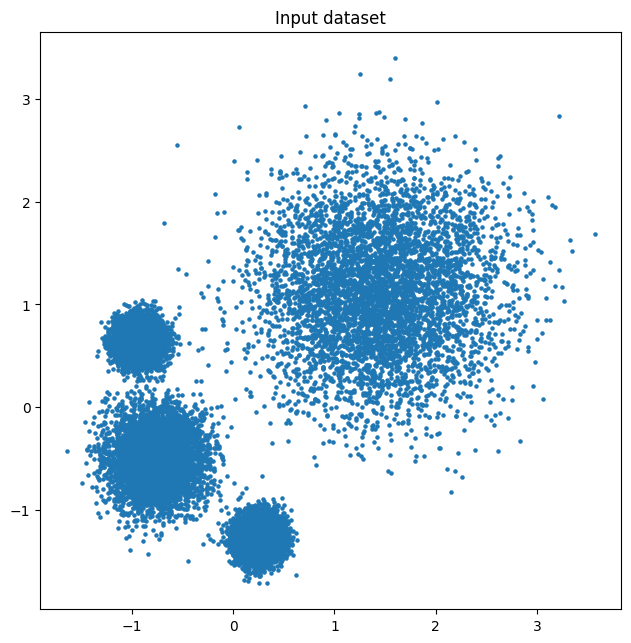

In [13]:
base_path = "/content/drive/MyDrive/sbsc/datasets/"
target_path = '' # path of the directory to save the results

filename, sep = "varied-variances.txt", "\t"

# loading the dataset
df = pd.read_csv(base_path + filename, sep=sep, header=None)
df, lab = df.iloc[:, :-1], df.iloc[:, -1].astype('int')

# K is the number of clusters, N is the number of data points, and f is the number of features
K = len(set(lab))
X = np.array(df, dtype='float32')
print(X.shape, K)

N, f = X.shape

if f == 2:
    plt.figure(plt.figure(figsize=(7.5, 7.5)))
    plt.scatter(X[:,0], X[:,1], color='C0', s=5)
    plt.title( 'Input dataset' )
    plt.show()

del df

CA for each iteration: 	0.999	0.999	0.999	0.999	0.999	0.999	0.999	0.999	0.999	0.999	

Avg. CA:  0.999

Avg. RI:  0.999

Avg. running time (sec):  1.1627338083999998


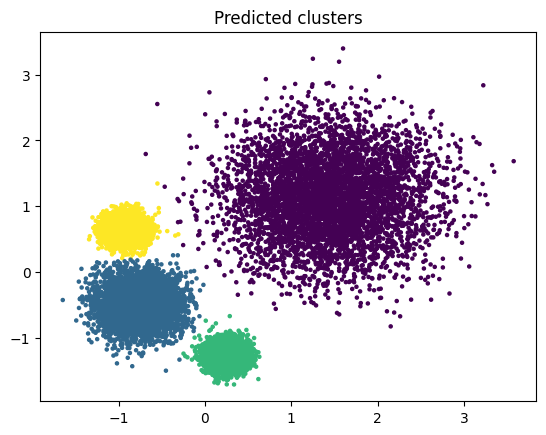

In [14]:
# set verbose=2 to save the results

rt, CAs, RIs, pred_labels = sbsc( X, K, num_iter=10, is_plot=False,
                        verbose=1, ds_name=filename, target_path=target_path )

max_ca_idx = np.argmax(CAs)


# Plotting best results
plt.scatter( X[:, 0], X[:, 1], c=pred_labels[:, max_ca_idx], s=5 )
plt.title( 'Predicted clusters' )
plt.show()

For a real dataset

In [15]:
base_path = "/content/drive/MyDrive/sbsc/datasets/"
target_path = '/content/drive/MyDrive/sbsc/predicted-labels/' # path of the directory to save the results

filename, sep = "letter.txt", "\t"

# loading the dataset
df = pd.read_csv(base_path + filename, sep=sep, header=None)
df, lab = df.iloc[:, :-1], df.iloc[:, -1].astype('int')

# K is the number of clusters, N is the number of data points, and f is the number of features
K = len(set(lab))
X = np.array(df, dtype='float32')
print(X.shape, K)

N, f = X.shape

del df

(20000, 16) 26


In [16]:
# set verbose=2 to save the results

rt, CAs, RIs, pred_labels = sbsc( X, K, num_iter=10,
                                 verbose=1, ds_name=filename, target_path=target_path )

CA for each iteration: 	0.3444	0.3566	0.3446	0.3403	0.3472	0.3402	0.3479	0.3422	0.3446	0.3399	

Avg. CA:  0.3448

Avg. RI:  0.9335

Avg. running time (sec):  2.2891311757000006


## Run with visualization

(1000, 2) 4


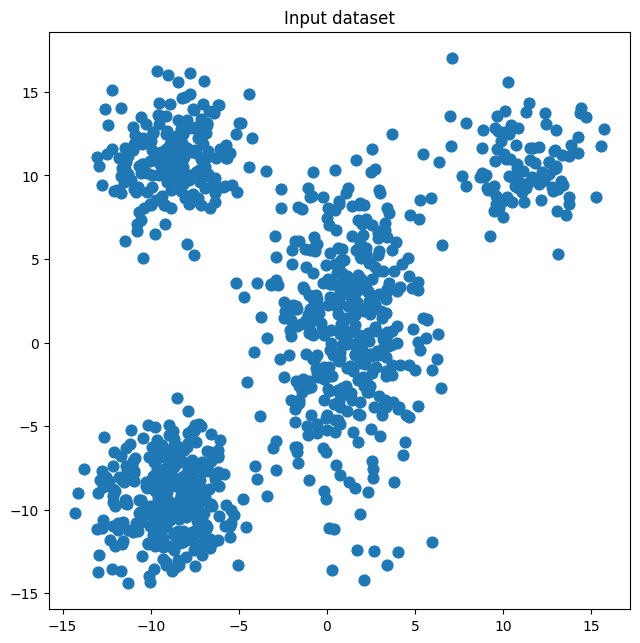

In [17]:
base_path = "/content/drive/MyDrive/sbsc/datasets/"
target_path = '/content/drive/MyDrive/sbsc/predicted-labels/' # path of the directory to save the results

filename, sep = "triangle2.txt", "\t"

# loading the dataset
df = pd.read_csv(base_path + filename, sep=sep, header=None)
df, lab = df.iloc[:, :-1], df.iloc[:, -1].astype('int')

# K is the number of clusters, N is the number of data points, and f is the number of features
K = len(set(lab))
X = np.array(df, dtype='float32')
print(X.shape, K)

N, f = X.shape

if f == 2:
    plt.figure(plt.figure(figsize=(7.5, 7.5)))
    plt.scatter(X[:,0], X[:,1], color='C0', s=60)
    plt.title( 'Input dataset' )
    plt.show()

del df

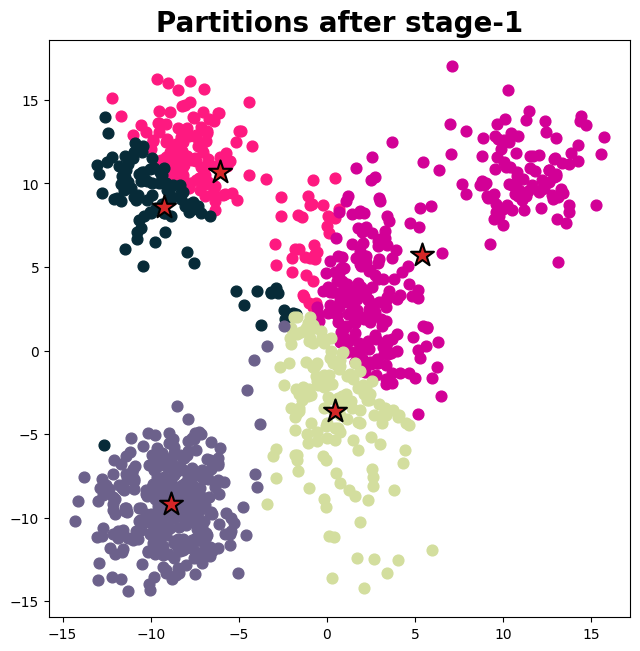

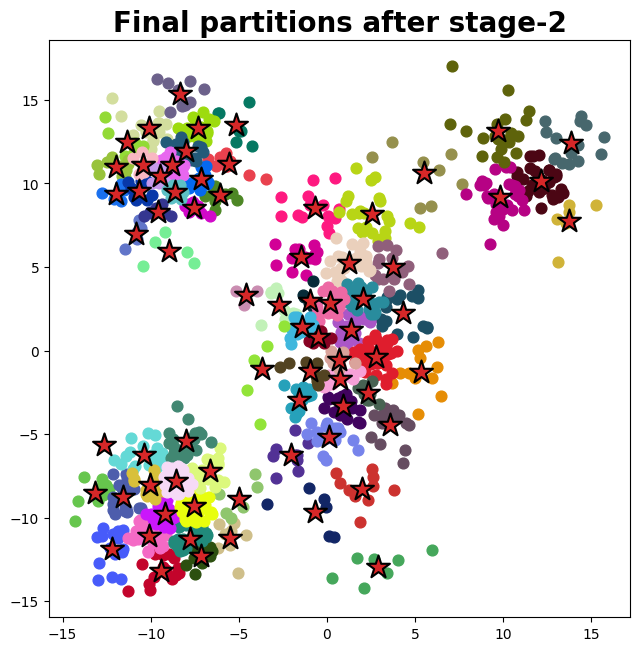

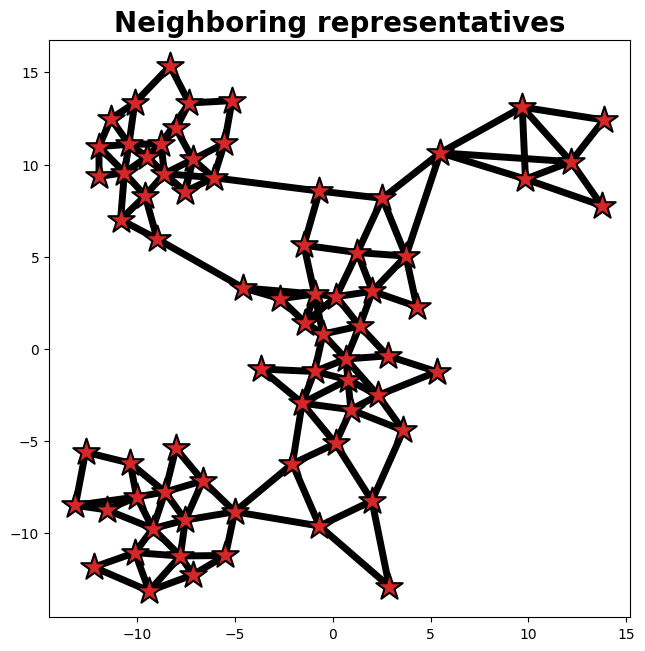

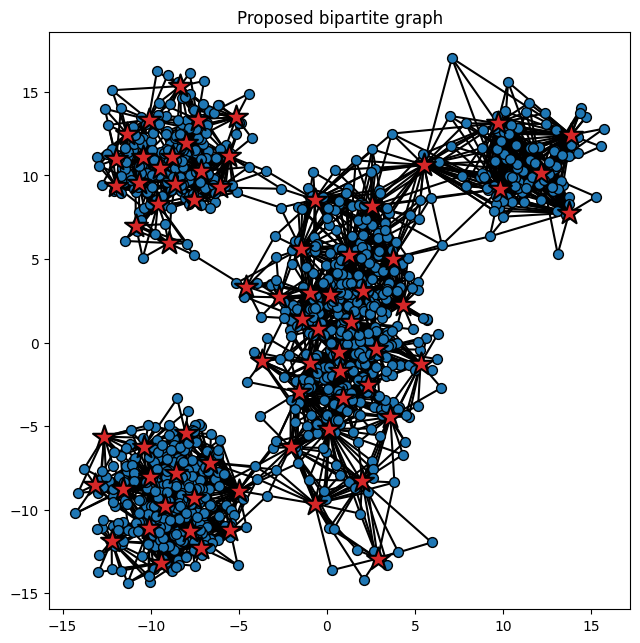

CA for each iteration: 	

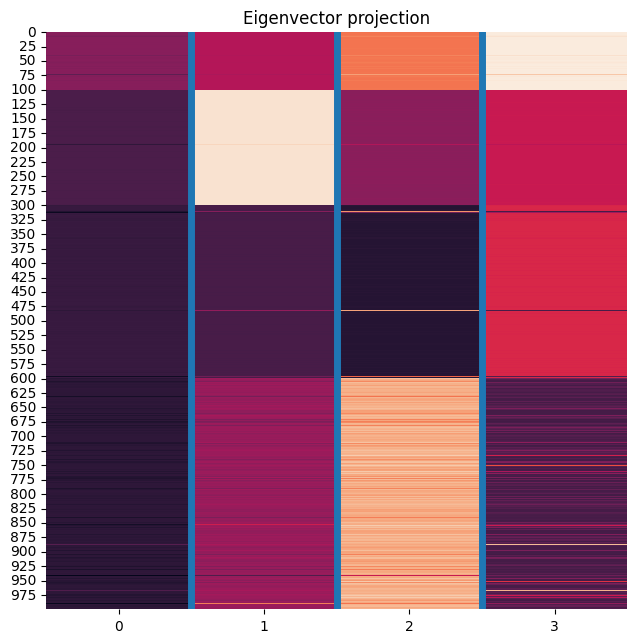

0.993	0.993	0.993	0.993	0.993	0.993	0.993	0.993	0.993	0.993	

Avg. CA:  0.993

Avg. RI:  0.9919

Avg. running time (sec):  4.7980196786999985


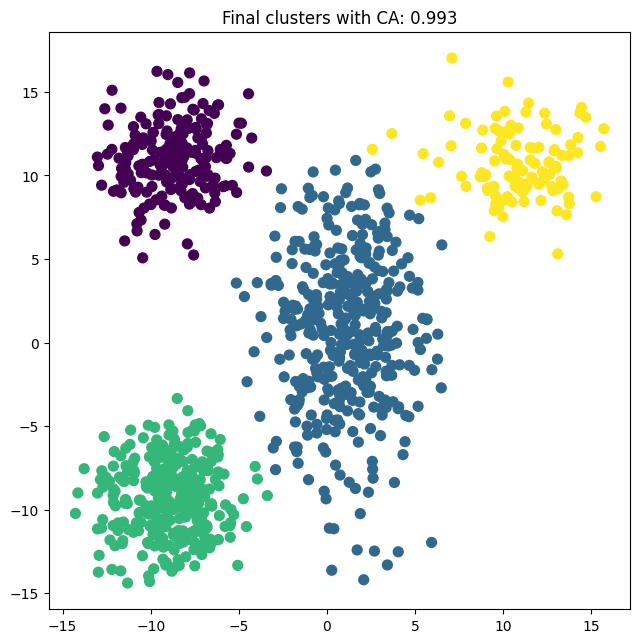

In [18]:
rt, CAs, RIs, pred_labels = sbsc( X, K, num_iter=10, is_plot=True,
                        verbose=1, ds_name=filename, target_path=target_path )

# Note: (1) If dataset is massive then the visualization part is time consuming.
#       (2) we have to set the paramaters related to plotting for different datasets

## Run multiple datasets

In [19]:
base_path = "/content/drive/MyDrive/sbsc/datasets/"
target_path = '/content/drive/MyDrive/sbsc/predicted-labels/' # path of the directory to save the labels
target_path_2 = '/content/drive/MyDrive/sbsc/results/' # path of the directory to save the results

CAs = []
RIs = []
RTs = []
verbose = 2

num_iter = 10
RT_arr = []

datasets = ['varied-variances.txt', 'spirals.txt', 'blobs-rings.txt',  'circles-moons.txt',  'noisy-blobs-50.csv',
            'occupancy-final.txt', 'pendigits.txt', 'letter.txt', 'shuttle.txt', 'gas_sensor.txt', 'isolet.txt', 'smartphones.txt',
             'covtype.txt', 'mnist-final.txt', 'helena.csv', 'WinnipegDataset.txt', 'dionis.csv', 'emnist-digits-train.csv']


seps = ['\t', '\t', '\t', '\t', ',',
        '\t', ',', '\t', ' ', '\t', '\t', '\t',
        ',', '\t', ',', ',', ',', ',']

print(len(datasets), len(seps))

co = 0

for filename in datasets[co:]:

    if filename == 'WinnipegDataset.txt':
        df = pd.read_csv(base_path + filename, sep=seps[co])
        df, lab = df.iloc[:, 1:], df.iloc[:, 0].astype('int')
    elif filename in ['helena.csv', 'dionis.csv', 'emnist-digits-train.csv']:
        df = pd.read_csv(base_path + filename, sep=seps[co], header=None)
        df, lab = df.iloc[:, 1:], df.iloc[:, 0].astype('int')
    else:
        df = pd.read_csv(base_path + filename, sep=seps[co], header=None)
        df, lab = df.iloc[:, :-1], df.iloc[:, -1].astype('int')

    K = len(set(lab))
    X = np.array(df, dtype='float32')
    N, f = X.shape

    if N < 500: continue

    print(co, filename[:10], N, f, K, sep='\t', end = '\n')

    max_iter = 15 if K >= 100 else 300

    noise = 1e-10

    if filename == 'occupancy-final.txt':
        noise = 1e-4
    elif filename == 'shuttle.txt':
        noise = 1e-5

    rt, CA_all, RI_all, labels_arr = sbsc(X, K, noise=noise, num_iter=num_iter, max_iter=max_iter, is_plot=False, verbose=verbose, ds_name=filename, target_path=target_path)

    CAs.append([filename] + CA_all + [np.round(np.mean(CA_all), 3), np.round(np.std(CA_all), 3), ])
    RIs.append([filename] + RI_all + [np.round(np.mean(RI_all), 3), np.round(np.std(RI_all), 3), ])
    RTs.append([filename, np.round(rt, 3)])


    co += 1

    df_CAs = pd.DataFrame( CAs, columns=[filename[:-4]] + ['iter-' + str(ite) for ite in range(num_iter)] + ['Avg. CA', 'std. CA'] )
    df_RIs = pd.DataFrame( RIs, columns=[filename[:-4]] + ['iter-' + str(ite) for ite in range(num_iter)] + ['Avg. CA', 'std. CA'] )
    df_RTs = pd.DataFrame( RTs, columns=[filename[:-4], 'Execution Time(sec)'])

    if verbose >= 2:
        df_CAs.to_csv(target_path_2 + "/ca_all.csv", sep=",", header=None, index=None)
        df_RIs.to_csv(target_path_2 + "/RI_all.csv", sep=",", header=None, index=None)
        df_RTs.to_csv(target_path_2 + "/RT_all.csv", sep=",", header=None, index=None)


df_CAs

18 18
0	varied-var	20000	2	4
CA for each iteration: 	0.999	0.999	0.999	0.999	0.999	0.999	0.999	0.999	0.999	0.999	

Avg. CA:  0.999

Avg. RI:  0.999

Avg. running time (sec):  0.702106346900002
1	spirals.tx	320000	2	4
CA for each iteration: 	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	

Avg. CA:  1.0

Avg. RI:  1.0

Avg. running time (sec):  9.190941369600004
2	blobs-ring	1000000	2	6
CA for each iteration: 	0.9999	0.9999	0.9999	0.9999	0.9999	0.9999	0.9999	0.9999	0.9999	0.9999	

Avg. CA:  0.9999

Avg. RI:  1.0

Avg. running time (sec):  23.397340632900004
3	circles-mo	10000000	2	4
CA for each iteration: 	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	

Avg. CA:  1.0

Avg. RI:  1.0

Avg. running time (sec):  228.99938872919998
4	noisy-blob	10000	2	50
CA for each iteration: 	0.8204	0.8245	0.8187	0.813	0.8671	0.8258	0.8229	0.8613	0.8255	0.8334	

Avg. CA:  0.8313

Avg. RI:  0.9913

Avg. running time (sec):  1.3318321923999747
5	occupancy-	10808	5	2
CA for each iteration: 	0.9842	0.9842	0.9842	0.9842	0.

/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (6). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


0.4271	0.4268	0.4268	0.4267	0.4268	

Avg. CA:  0.4269

Avg. RI:  0.7167

Avg. running time (sec):  1.2195380808999743
10	isolet.txt	7797	617	26
CA for each iteration: 	0.5786	0.5512	0.5438	0.5588	0.5696	0.5809	0.5564	0.5857	0.5686	0.5389	

Avg. CA:  0.5632

Avg. RI:  0.959

Avg. running time (sec):  1.9351403664998088
11	smartphone	10929	561	12
CA for each iteration: 	0.6821	0.6529	0.6798	0.6666	0.6767	0.6278	0.6453	0.6767	0.6579	0.6679	

Avg. CA:  0.6634

Avg. RI:  0.8972

Avg. running time (sec):  3.0193675438001266
12	covtype.tx	581012	54	7
CA for each iteration: 	0.2728	0.2728	0.2731	0.2728	0.2728	0.2728	0.2626	0.2728	0.2627	0.2648	

Avg. CA:  0.27

Avg. RI:  0.5878

Avg. running time (sec):  29.137899809900112
13	mnist-fina	70000	784	10
CA for each iteration: 	0.773	0.7751	0.7729	0.7685	0.7729	0.7729	0.7533	0.7729	0.773	0.773	

Avg. CA:  0.7708

Avg. RI:  0.9341

Avg. running time (sec):  26.23826544880012
14	helena.csv	65196	27	100
CA for each iteration: 	0.0844	0.0861	0.0859	0.0

,emnist-digits-train,iter-0,iter-1,iter-2,iter-3,iter-4,iter-5,iter-6,iter-7,iter-8,iter-9,Avg. CA,std. CA
0,varied-variances.txt,0.999000,0.999000,0.999000,0.999000,0.999000,0.999000,0.999000,0.999000,0.999000,0.999000,0.999,0.000
1,spirals.txt,0.999956,0.999956,0.999956,0.999956,0.999956,0.999956,0.999956,0.999956,0.999956,0.999956,1.000,0.000
2,blobs-rings.txt,0.999925,0.999921,0.999928,0.999922,0.999921,0.999922,0.999921,0.999922,0.999921,0.999927,1.000,0.000
3,circles-moons.txt,0.999956,0.999956,0.999956,0.999956,0.999956,0.999956,0.999956,0.999956,0.999956,0.999956,1.000,0.000
4,noisy-blobs-50.csv,0.820400,0.824500,0.818700,0.813000,0.867100,0.825800,0.822900,0.861300,0.825500,0.833400,0.831,0.017
5,occupancy-final.txt,0.984178,0.984178,0.984178,0.984178,0.984178,0.984178,0.984178,0.984178,0.984178,0.984178,0.984,0.000
6,pendigits.txt,0.812318,0.869996,0.869996,0.812409,0.869996,0.869996,0.810499,0.869996,0.874636,0.869996,0.853,0.027
7,letter.txt,0.354650,0.353650,0.348700,0.345400,0.343850,0.347250,0.347000,0.350550,0.333950,0.350550,0.348,0.006
8,shuttle.txt,0.903862,0.917655,0.918483,0.903885,0.917517,0.903218,0.903057,0.902920,0.902920,0.888115,0.906,0.009
9,gas_sensor.txt,0.427175,0.426743,0.426815,0.427103,0.426743,0.427103,0.426815,0.426815,0.426743,0.426815,0.427,0.000


In [20]:
df_RIs

,emnist-digits-train,iter-0,iter-1,iter-2,iter-3,iter-4,iter-5,iter-6,iter-7,iter-8,iter-9,Avg. CA,std. CA
0,varied-variances.txt,0.999001,0.999001,0.999001,0.999001,0.999001,0.999001,0.999001,0.999001,0.999001,0.999001,0.999,0.000
1,spirals.txt,0.999956,0.999956,0.999956,0.999956,0.999956,0.999956,0.999956,0.999956,0.999956,0.999956,1.000,0.000
2,blobs-rings.txt,0.999955,0.999950,0.999956,0.999951,0.999953,0.999951,0.999953,0.999951,0.999953,0.999956,1.000,0.000
3,circles-moons.txt,0.999956,0.999956,0.999956,0.999956,0.999956,0.999956,0.999956,0.999956,0.999956,0.999956,1.000,0.000
4,noisy-blobs-50.csv,0.990607,0.991649,0.990657,0.990353,0.992655,0.990942,0.990732,0.991576,0.991695,0.992018,0.991,0.001
5,occupancy-final.txt,0.968855,0.968855,0.968855,0.968855,0.968855,0.968855,0.968855,0.968855,0.968855,0.968855,0.969,0.000
6,pendigits.txt,0.941837,0.956938,0.956585,0.941832,0.956494,0.956494,0.945000,0.956938,0.958235,0.956585,0.953,0.006
7,letter.txt,0.933585,0.928514,0.931833,0.934793,0.931221,0.931461,0.932707,0.935959,0.930712,0.936376,0.933,0.002
8,shuttle.txt,0.865701,0.866963,0.865771,0.865227,0.865322,0.864357,0.953909,0.864800,0.953800,0.953549,0.892,0.040
9,gas_sensor.txt,0.716819,0.716612,0.716669,0.716799,0.716612,0.716799,0.716669,0.716644,0.716612,0.716644,0.717,0.000


In [21]:
df_RTs

,emnist-digits-train,Execution Time(sec)
0,varied-variances.txt,0.702
1,spirals.txt,9.191
2,blobs-rings.txt,23.397
3,circles-moons.txt,228.999
4,noisy-blobs-50.csv,1.332
5,occupancy-final.txt,0.503
6,pendigits.txt,0.815
7,letter.txt,1.782
8,shuttle.txt,1.929
9,gas_sensor.txt,1.220


## Cluster Analysis

18 18
0	varied-var	20000	2	4


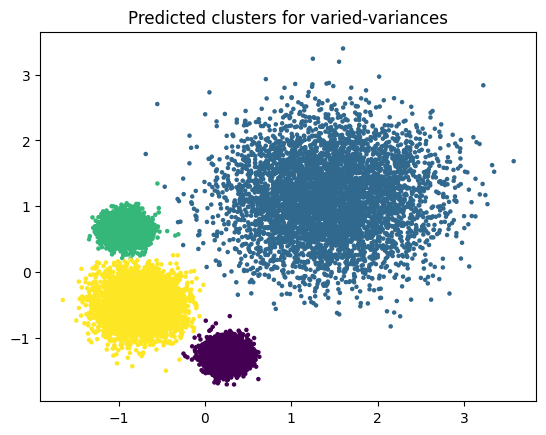

1	spirals.tx	320000	2	4


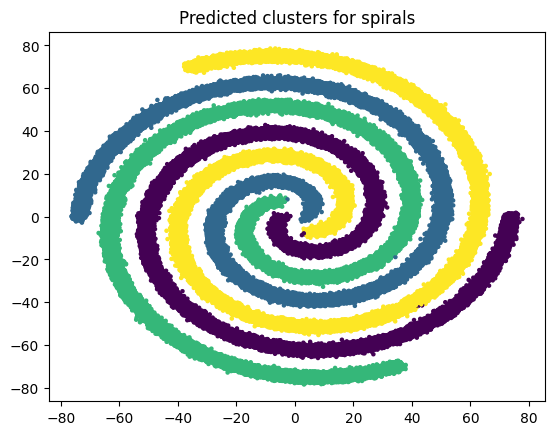

2	blobs-ring	1000000	2	6


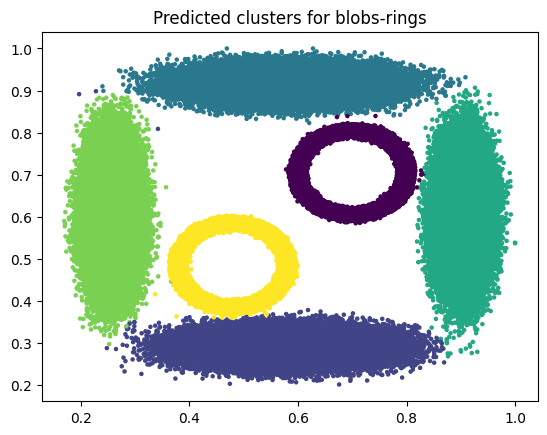

3	circles-mo	10000000	2	4


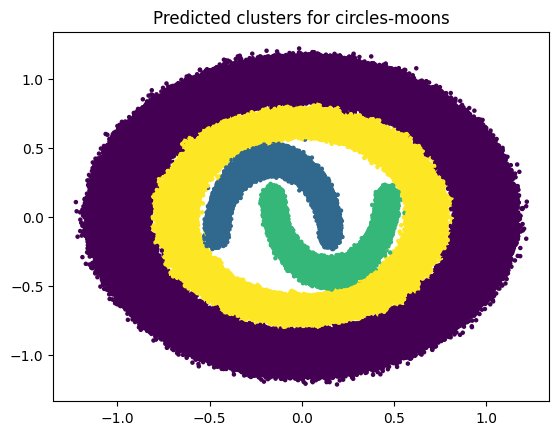

4	noisy-blob	10000	2	50


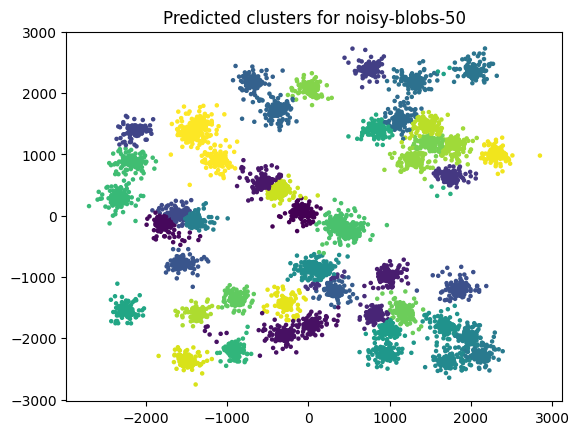

5	occupancy-	10808	5	2
6	pendigits.	10992	16	10
7	letter.txt	20000	16	26
8	shuttle.tx	43500	9	7
9	gas_sensor	13910	129	6
10	isolet.txt	7797	617	26
11	smartphone	10929	561	12
12	covtype.tx	581012	54	7
13	mnist-fina	70000	784	10
14	helena.csv	65196	27	100
15	WinnipegDa	325834	174	7
16	dionis.csv	416188	60	355
17	emnist-dig	240000	784	10


,emnist-digits-train,iter-0,iter-1,iter-2,iter-3,iter-4,iter-5,iter-6,iter-7,iter-8,iter-9,Avg. CA,std. CA
0,varied-variances.txt,0.999000,0.999000,0.999000,0.999000,0.999000,0.999000,0.999000,0.999000,0.999000,0.999000,0.999,0.000
1,spirals.txt,0.999956,0.999956,0.999956,0.999956,0.999956,0.999956,0.999956,0.999956,0.999956,0.999956,1.000,0.000
2,blobs-rings.txt,0.999925,0.999921,0.999928,0.999922,0.999921,0.999922,0.999921,0.999922,0.999921,0.999927,1.000,0.000
3,circles-moons.txt,0.999956,0.999956,0.999956,0.999956,0.999956,0.999956,0.999956,0.999956,0.999956,0.999956,1.000,0.000
4,noisy-blobs-50.csv,0.820400,0.824500,0.818700,0.813000,0.867100,0.825800,0.822900,0.861300,0.825500,0.833400,0.831,0.017
5,occupancy-final.txt,0.984178,0.984178,0.984178,0.984178,0.984178,0.984178,0.984178,0.984178,0.984178,0.984178,0.984,0.000
6,pendigits.txt,0.812318,0.869996,0.869996,0.812409,0.869996,0.869996,0.810499,0.869996,0.874636,0.869996,0.853,0.027
7,letter.txt,0.354650,0.353650,0.348700,0.345400,0.343850,0.347250,0.347000,0.350550,0.333950,0.350550,0.348,0.006
8,shuttle.txt,0.903862,0.917655,0.918483,0.903885,0.917517,0.903218,0.903057,0.902920,0.902920,0.888115,0.906,0.009
9,gas_sensor.txt,0.427175,0.426743,0.426815,0.427103,0.426743,0.427103,0.426815,0.426815,0.426743,0.426815,0.427,0.000


In [22]:
base_path = "/content/drive/MyDrive/sbsc/datasets/"
target_path = '/content/drive/MyDrive/sbsc/predicted-labels/' # path of the directory to save the labels
target_path_2 = '/content/drive/MyDrive/sbsc/results/' # path of the directory to save the results

CAs = []
RIs = []

verbose=2

num_iter = 10
RT_arr = []

datasets = ['varied-variances.txt', 'spirals.txt', 'blobs-rings.txt',  'circles-moons.txt',  'noisy-blobs-50.csv',
            'occupancy-final.txt', 'pendigits.txt', 'letter.txt', 'shuttle.txt', 'gas_sensor.txt', 'isolet.txt', 'smartphones.txt',
             'covtype.txt', 'mnist-final.txt', 'helena.csv', 'WinnipegDataset.txt', 'dionis.csv', 'emnist-digits-train.csv']


seps = ['\t', '\t', '\t', '\t', ',',
        '\t', ',', '\t', ' ', '\t', '\t', '\t',
        ',', '\t', ',', ',', ',', ',']

print(len(datasets), len(seps))

co = 0

for filename in datasets[co:]:


    if filename == 'WinnipegDataset.txt':
        df = pd.read_csv(base_path + filename, sep=seps[co])
        df, lab = df.iloc[:, 1:], df.iloc[:, 0].astype('int')
    elif filename in ['helena.csv', 'dionis.csv', 'emnist-digits-train.csv']:
        df = pd.read_csv(base_path + filename, sep=seps[co], header=None)
        df, lab = df.iloc[:, 1:], df.iloc[:, 0].astype('int')
    else:
        df = pd.read_csv(base_path + filename, sep=seps[co], header=None)
        df, lab = df.iloc[:, :-1], df.iloc[:, -1].astype('int')

    K = len(set(lab))
    X = np.array(df, dtype='float32')
    N, f = X.shape

    print(co, filename[:10], N, f, K, sep='\t', end = '\n')

    CA_all = []
    RI_all = []

    labels_arr = pd.read_csv( target_path + "sbsc-pred-labels-" + filename[:-4] + ".csv", sep=",", header=None  )

    for idx in range(labels_arr.shape[1]):

        pred_labels = np.array(labels_arr.iloc[:, idx], dtype=int)

        CA_all.append(clustering_accuracy(lab, pred_labels))

        RI_all.append(rand_index_score(lab, pred_labels))


    # Plotting best results
    if f == 2:
        max_ca_idx = np.argmax(CA_all)
        plt.scatter( X[:, 0], X[:, 1], c=labels_arr.iloc[:, max_ca_idx], s=5 )
        plt.title( 'Predicted clusters for ' + filename[:-4] )
        plt.show()


    CAs.append([filename] + CA_all + [np.round(np.mean(CA_all), 3), np.round(np.std(CA_all), 3), ])
    RIs.append([filename] + RI_all + [np.round(np.mean(RI_all), 3), np.round(np.std(RI_all), 3), ])

    co += 1

    df_CAs = pd.DataFrame( CAs, columns=[filename[:-4]] + ['iter-' + str(ite) for ite in range(num_iter)] + ['Avg. CA', 'std. CA'] )
    df_RIs = pd.DataFrame( RIs, columns=[filename[:-4]] + ['iter-' + str(ite) for ite in range(num_iter)] + ['Avg. CA', 'std. CA'] )

    if verbose >= 2:
        df_CAs.to_csv(target_path_2 + "/ca_all.csv", sep=",", header=None, index=None)
        df_RIs.to_csv(target_path_2 + "/RI_all.csv", sep=",", header=None, index=None)

df_CAs

In [23]:
df_RIs

,emnist-digits-train,iter-0,iter-1,iter-2,iter-3,iter-4,iter-5,iter-6,iter-7,iter-8,iter-9,Avg. CA,std. CA
0,varied-variances.txt,0.999001,0.999001,0.999001,0.999001,0.999001,0.999001,0.999001,0.999001,0.999001,0.999001,0.999,0.000
1,spirals.txt,0.999956,0.999956,0.999956,0.999956,0.999956,0.999956,0.999956,0.999956,0.999956,0.999956,1.000,0.000
2,blobs-rings.txt,0.999955,0.999950,0.999956,0.999951,0.999953,0.999951,0.999953,0.999951,0.999953,0.999956,1.000,0.000
3,circles-moons.txt,0.999956,0.999956,0.999956,0.999956,0.999956,0.999956,0.999956,0.999956,0.999956,0.999956,1.000,0.000
4,noisy-blobs-50.csv,0.990607,0.991649,0.990657,0.990353,0.992655,0.990942,0.990732,0.991576,0.991695,0.992018,0.991,0.001
5,occupancy-final.txt,0.968855,0.968855,0.968855,0.968855,0.968855,0.968855,0.968855,0.968855,0.968855,0.968855,0.969,0.000
6,pendigits.txt,0.941837,0.956938,0.956585,0.941832,0.956494,0.956494,0.945000,0.956938,0.958235,0.956585,0.953,0.006
7,letter.txt,0.933585,0.928514,0.931833,0.934793,0.931221,0.931461,0.932707,0.935959,0.930712,0.936376,0.933,0.002
8,shuttle.txt,0.865701,0.866963,0.865771,0.865227,0.865322,0.864357,0.953909,0.864800,0.953800,0.953549,0.892,0.040
9,gas_sensor.txt,0.716819,0.716612,0.716669,0.716799,0.716612,0.716799,0.716669,0.716644,0.716612,0.716644,0.717,0.000
